# Data

## Kaggle (source image)

In [ ]:
# Colab library to upload files to notebook
from google.colab import files
# Install Kaggle library
!pip install -q kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/food41

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [01:14<00:00, 73.0MB/s]
100% 5.30G/5.30G [01:14<00:00, 76.5MB/s]


In [ ]:
!unzip food41.zip

## nutrition facts

In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/gabrielilharco/snap-n-eat/master/data/nutrition_values.csv'
df1 = pd.read_csv(url)
df1['product'] = df1['product_name'].replace(' ', '_', regex=True)
df1.head(2)

,product_name,energy_100g,carbohydrates_100g,sugars_100g,proteins_100g,fat_100g,fiber_100g,cholesterol_100g,product
0,apple pie,272.789289,37.464889,15.074,2.841556,13.439778,2.148889,0.0058,apple_pie
1,baby back ribs,228.962000,10.710000,7.140,14.290000,14.290000,0.000000,0.0540,baby_back_ribs


## split data

In [ ]:
list_filter = list(df1['product']) #get name of food with complete food information

In [ ]:
!ls images

In [ ]:
import shutil

image_directory = 'images/'
directory = 'data/'
for name in list_filter:
  shutil.copytree(image_directory+name, directory+name)

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('data', output="image", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 59000 files [00:40, 1448.17 files/s]


In [ ]:
!ls image/test

apple_pie	    donuts	       macaroni_and_cheese
baby_back_ribs	    dumplings	       miso_soup
baklava		    edamame	       mussels
bread_pudding	    falafel	       onion_rings
breakfast_burrito   french_fries       pad_thai
bruschetta	    french_onion_soup  paella
caesar_salad	    french_toast       pancakes
caprese_salad	    frozen_yogurt      pizza
carrot_cake	    garlic_bread       ramen
cheesecake	    gnocchi	       ravioli
chicken_curry	    greek_salad        red_velvet_cake
chicken_quesadilla  grilled_salmon     risotto
chicken_wings	    guacamole	       scallops
chocolate_cake	    hamburger	       seaweed_salad
chocolate_mousse    hot_dog	       spaghetti_bolognese
churros		    huevos_rancheros   spring_rolls
clam_chowder	    hummus	       strawberry_shortcake
crab_cakes	    ice_cream	       tiramisu
creme_brulee	    lasagna	       waffles
deviled_eggs	    lobster_bisque


In [ ]:
!ls image/

test  train  val


# Augmented image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'image/train/'
validation_dir = 'image/test/'
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 47200 images belonging to 59 classes.
Found 5900 images belonging to 59 classes.


# Model InceptionV3

In [ ]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


In [ ]:
from tensorflow.keras.optimizers import RMSprop

n_class = len(list_filter)
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (n_class, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['categorical_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import *
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001, mode='min')
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
callbacks_list = [ 
                  reduce_lr,
                  earlystopper 
                  ]
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            callbacks=callbacks_list,
            verbose = 2)

Epoch 1/20
100/100 - 175s - loss: 3.7538 - categorical_accuracy: 0.1085 - val_loss: 3.0734 - val_categorical_accuracy: 0.2360
Epoch 2/20
100/100 - 162s - loss: 3.2449 - categorical_accuracy: 0.2120 - val_loss: 2.7442 - val_categorical_accuracy: 0.3020
Epoch 3/20
100/100 - 162s - loss: 2.9384 - categorical_accuracy: 0.2690 - val_loss: 2.4224 - val_categorical_accuracy: 0.3720
Epoch 4/20
100/100 - 161s - loss: 2.8256 - categorical_accuracy: 0.2940 - val_loss: 2.4118 - val_categorical_accuracy: 0.3810
Epoch 5/20
100/100 - 166s - loss: 2.6411 - categorical_accuracy: 0.3345 - val_loss: 2.2919 - val_categorical_accuracy: 0.4000
Epoch 6/20
100/100 - 161s - loss: 2.6064 - categorical_accuracy: 0.3375 - val_loss: 2.1340 - val_categorical_accuracy: 0.4260
Epoch 7/20
100/100 - 161s - loss: 2.4936 - categorical_accuracy: 0.3625 - val_loss: 2.2639 - val_categorical_accuracy: 0.3810
Epoch 8/20
100/100 - 161s - loss: 2.4792 - categorical_accuracy: 0.3645 - val_loss: 2.0140 - val_categorical_accuracy:

## evaluate

In [ ]:
model.evaluate(validation_generator)

295/295 [==============================] - 242s 819ms/step - loss: 1.8493 - categorical_accuracy: 0.5100


[1.8492803573608398, 0.5099999904632568]

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the model.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_categorical_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

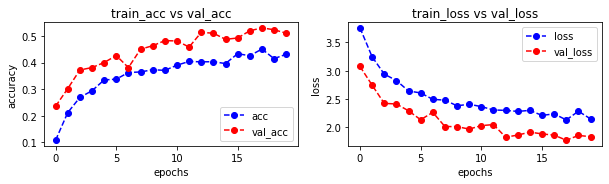

In [ ]:
plot_accuracy_loss(history)

## Saving Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

model.save("/content/gdrive/My Drive/1_InceptionV3.h5")

# Mislabel

In [ ]:
# make a prediction
predictions = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
test_labels = validation_generator.classes
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = validation_generator.classes

In [ ]:
def label_name(label_index):
  for name, label in train_generator.class_indices.items():
    if label == label_index:
      return name

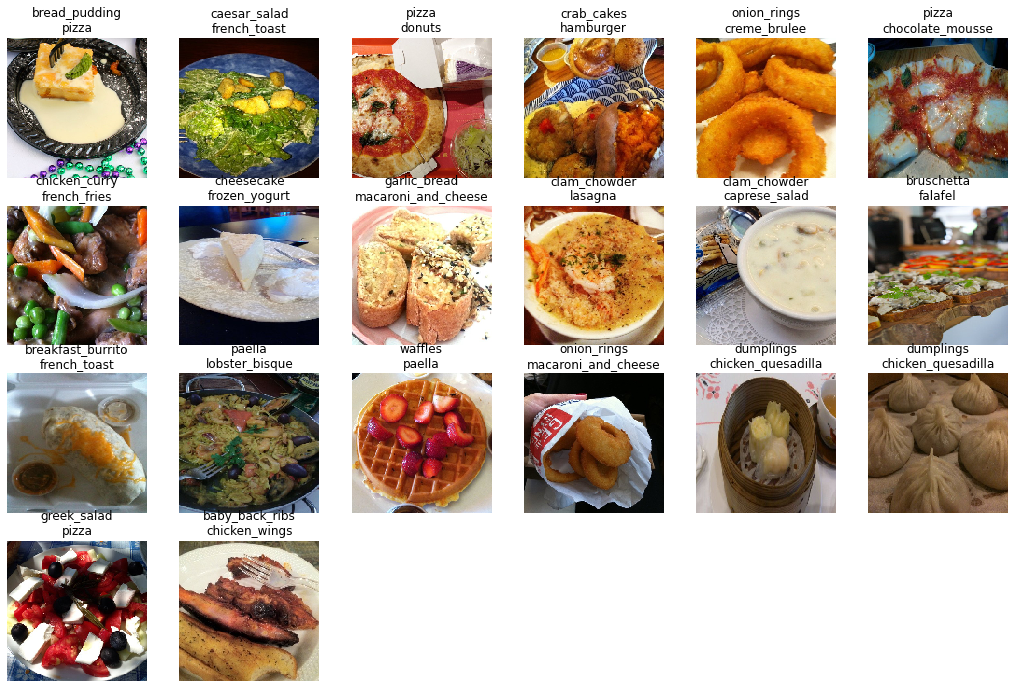

In [ ]:
import numpy as np

x, y = validation_generator.next()

plt.figure(figsize=(18, 18))
for i, (img, label) in enumerate(zip(x, y)):
    label_index = np.where(label == 1)
    title_label = label_name(label_index[0][0])
    if label_index != y_pred[i]:
      plt.subplot(6, 6, i+1)
      title_pred = label_name(y_pred[i])
      plt.title(title_label+'\n'+title_pred) #product, predict
      plt.axis('off')
      plt.imshow(img, interpolation="nearest")

# Test

Saving 1103986.jpg to 1103986 (5).jpg
clam_chowder


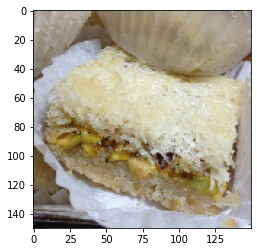

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  y_pred_index = np.argmax(classes[0])
  title_pred = label_name(y_pred_index)
  
  print(title_pred)
  plt.imshow(img)
 

# Load Model
https://www.dropbox.com/s/3ejl39hoqpdfla9/1_InceptionV3.zip?dl=0

https://www.dropbox.com/s/v5ghg48pb8ge219/1_InceptionV3.h5?dl=0

In [ ]:
!wget --no-check-certificate "https://www.dropbox.com/s/3ejl39hoqpdfla9/1_InceptionV3.zip?dl=0"
!unzip 1_InceptionV3.zip?dl=0

In [ ]:
from keras.models import load_model

link_model = "/content/1_InceptionV3.h5"
model = load_model(link_model)
model.summary()